In [1]:
import numpy as np
import random
import os
import librosa.display
import IPython.display as lpd # Listening the audio
import matplotlib.pyplot as plt # Plotting coefficients

In [2]:
# Global variables
AUDIO_TRAIN_PATH = "../Data/Audio/Train"
AUDIO_VAL_PATH = "../Data/Audio/Val"
AUDIO_TEST_PATH = "../Data/Audio/Test"

LABELS_TRAIN_PATH = "../Data/Tags/Train"
LABELS_VAL_PATH = "../Data/Tags/Val"
LABELS_TEST_PATH = "../Data/Tags/Test"



In [3]:
def total_positives(smeared_data):
    
    total = smeared_data.shape[0]
    positive_labels_count = [1 for label in smeared_data if label > 0]
    pos = len(positive_labels_count)
    
    return pos, round(pos/total,3)

def get_paths(dataset, resolution, context):
   
    """ Get directory paths"""
    
    if dataset.lower() == "train":
        audio_dir = AUDIO_TRAIN_PATH
        labels_dir = LABELS_TRAIN_PATH
    elif dataset.lower() == "val":
        audio_dir = AUDIO_VAL_PATH
        labels_dir = LABELS_VAL_PATH
    elif dataset.lower() == "test":
        audio_dir = AUDIO_TEST_PATH
        labels_dir = LABELS_TEST_PATH
    
    sufix = resolution.capitalize() + "_" + str(context)
    
    features_dir = audio_dir + "/Features/" + sufix
    original_labels_dir = labels_dir + "/Arrays/" + sufix + "/original"
    smeared_labels_dir = labels_dir + "/Arrays/" + sufix + "/smeared"
    
    return audio_dir, labels_dir, features_dir, original_labels_dir, smeared_labels_dir
    

def get_data(dataset, resolution, context, n_songs ):
    
    """ Load all data from dataset (X/Y samples) into numpy arrays. 
        Also creates a dictionary of selected songs which its X shapes
    """
    # Get directories
    audio_dir, labels_dir, features_dir, original_labels_dir, smeared_labels_dir = get_paths(dataset, resolution, context)
    
    # Get song names of whole dataset
    names = []
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(audio_dir,'.')):
        if len(filenames) > 0 and dirpath == audio_dir + '\.':
            names = filenames
    
    # Get as many song as indicated in n_songs
    while n_songs < len(names):
        song = random.choice(names)
        names.remove(song)
    
    # Get dataset and info related
    X_dict = {}
    Y_dict = {}
    X_dataset = None
    Y_dataset = None
    oY_dataset = None #labels without smearing
    sufix = resolution.capitalize() + "_" + str(context)
    
    for song_name in names:
        X_data = np.load(
                     os.path.join(features_dir, song_name[:-4] + "_X_" + sufix + ".npy")
                    )
        Y_data = np.load(
                     os.path.join(smeared_labels_dir, song_name[:-4] + "_sY_" + sufix + ".npy")
                    )
        oY_data = np.load(
                     os.path.join(original_labels_dir, song_name[:-4] + "_oY_" + sufix + ".npy")
                    )
        
        X_dict[song_name[:-4]] = X_data.shape
        positives , porcentage  = total_positives(Y_data)
        Y_dict[song_name[:-4]] = (positives, porcentage)
        
        #concatenate each song to create dataset
        if np.any(X_dataset) == None:
            X_dataset = X_data
            Y_dataset = Y_data
            oY_dataset = oY_data
        else:
            X_dataset = np.concatenate((X_dataset,X_data))
            Y_dataset = np.concatenate((Y_dataset,Y_data))
            oY_dataset = np.concatenate((oY_dataset,oY_data))
            
    
    return X_dataset, Y_dataset, oY_dataset, X_dict, Y_dict
    
    

In [4]:
class Dataset():
    
    def __init__(self, type, resolution, context, n_songs, seed=None):
        if seed != None:
            random.seed(seed)
        self.X_data, self.Y_data, self.oY_data, self.X_info, self.Y_info = get_data(type, resolution, context, n_songs)
        self.type = [type, resolution, context ]
        pos, perc = total_positives(self.Y_data)
        self.positives = (pos, perc)
        self.details()
        
    
    def details(self):
        
        pos, perc = total_positives(self.Y_data)
        self.positives = (pos, perc)
        
        print("----------------------------------------------------------------------------------\n\n")
        print(self.type[0].capitalize()+ " dataset " + self.type[1].capitalize() + "_" + str(self.type[2]))
        
        print(f"\nTotal examples : {self.X_data.shape[0]}.  Positive Labeled: {self.positives[0]}, {self.positives[1]*100}%")
        print(f"Shape of samples : {self.X_data.shape[1:]}. Total songs: {len(self.X_info.items())}  \n")
        print(".....................................................................................")
        
    
    def boost_positives(self, factor):
        
        total = int(self.positives[0]*factor)
        labels_index_list = np.where(self.Y_data > 0)[0]
        dup_labels_list = []
        while len(dup_labels_list) != total - self.positives[0]:
            dup_index = random.choice(labels_index_list)
            dup_labels_list.append(dup_index)
        
        new_X = self.X_data[dup_labels_list, :,:,:]
        new_Y = self.Y_data[dup_labels_list, :]
        self.X_data = np.concatenate((self.X_data, new_X))
        self.Y_data = np.concatenate((self.Y_data, new_Y))
        self.details()
    
    def show_features(self, slice=None, n_song=None, n_frames=200):
        
        if slice == None:
            if n_song == None:
                slice = random.randint(0, self.X_data.shape[0])
            else:
                song_frames = [shape[0] for (song, shape) in self.X_info.items()]
                song_names = [song for (song, shape) in self.X_info.items()]
                if n_song == 1:
                    slice = 0 + int(self.X_data.shape[1]/2)
                    n_frames = song_frames[0]
                else:
                    slice = 0
                    for i in range(n_song-1):
                        slice += song_frames[i]
                    
                    slice += int(self.X_data.shape[1]/2)
                    n_frames = song_frames[n_song-1]
        
        
        # Plot Labels
        plt.figure(figsize=(25,10))
        y_labels_slice = self.oY_data[slice:slice+n_frames,0]
        y_labels_index = np.where(y_labels_slice > 0)[0]
        y_convolve_slice = self.Y_data[slice:slice+n_frames,0]
        for index in y_labels_index:
            plt.axvline(x=index, color="r")
        plt.plot(y_convolve_slice)
        if n_song != None:
            plt.title(f"Y labels from: {song_names[n_song-1]}")
        else:
            plt.title(f"Augmented zone from y: {slice} to y: {slice+n_frames}")
            
        # Plot Features
        fig = plt.figure(figsize=(25,10))  
        columns = 3
        rows = 3

        for i in range(1, columns*rows + 1):
            plt.subplot(rows,columns,i, ymargin=20)
            img = self.X_data[i+slice,:,:,0].T
            librosa.display.specshow(img, sr=44100, hop_length=1024)
            plt.colorbar(format="%+2f")
            plt.title(f'Slice {i+slice}. y ={self.Y_data[i+slice,:]}')
        plt.show()
    
    def play_song(self, n_song):
        song_names = [song for (song, shape) in self.X_info.items()]
        audio_dir, _, _, _, _ = get_paths(self.type[0].capitalize(), self.type[1].capitalize(), self.type[2])
        audio_path = os.path.join(audio_dir, song_names[n_song-1] + ".mp3")
        return lpd.Audio(audio_path)
        
                    
        
                        
                        
                    
                
        

            
        

In [137]:
test_x, test_y, y_label, x_info, y_info =get_data(dataset="Train", resolution="High", context=8, n_songs=10)

In [17]:
train = Dataset(type="Train", resolution="Mid", context=16, n_songs=10)

----------------------------------------------------------------------------------


Train dataset Mid_16

Total examples : 14342.  Positive Labeled: 2795, 19.5%
Shape of samples : (114, 80, 1). Total songs: 10  

.....................................................................................


In [252]:
train.boost_positives(3)

----------------------------------------------------------------------------------


Train dataset Mid_8

Total examples : 19646.  Positive Labeled: 8715, 44.4%
Shape of samples : (58, 80, 1).  

.....................................................................................


In [18]:
train.X_info

{'09.  P!nk  -  Walk Me Home': (1274, 114, 80, 1),
 "12.  Calvin Harris & Rag'n'Bone Man  -  Giant": (1646, 114, 80, 1),
 '15.  Dan x Shay & Justin Bieber  -  10,000 Hours': (1204, 114, 80, 1),
 'Alesso-Remedy': (1423, 114, 80, 1),
 'Fais-Afrojack-Hey': (1548, 114, 80, 1),
 'Kygo, Rita Ora - Carry On': (1270, 114, 80, 1),
 'Martin Garrix-Home': (2064, 114, 80, 1),
 'R3hab-All-around-the-world-la-la-la': (1062, 114, 80, 1),
 'Sigala, Becky Hill - Wish You Well': (1476, 114, 80, 1),
 'Sofi-tukker-Drinkee': (1375, 114, 80, 1)}

In [19]:
train.play_song(n_song=9)

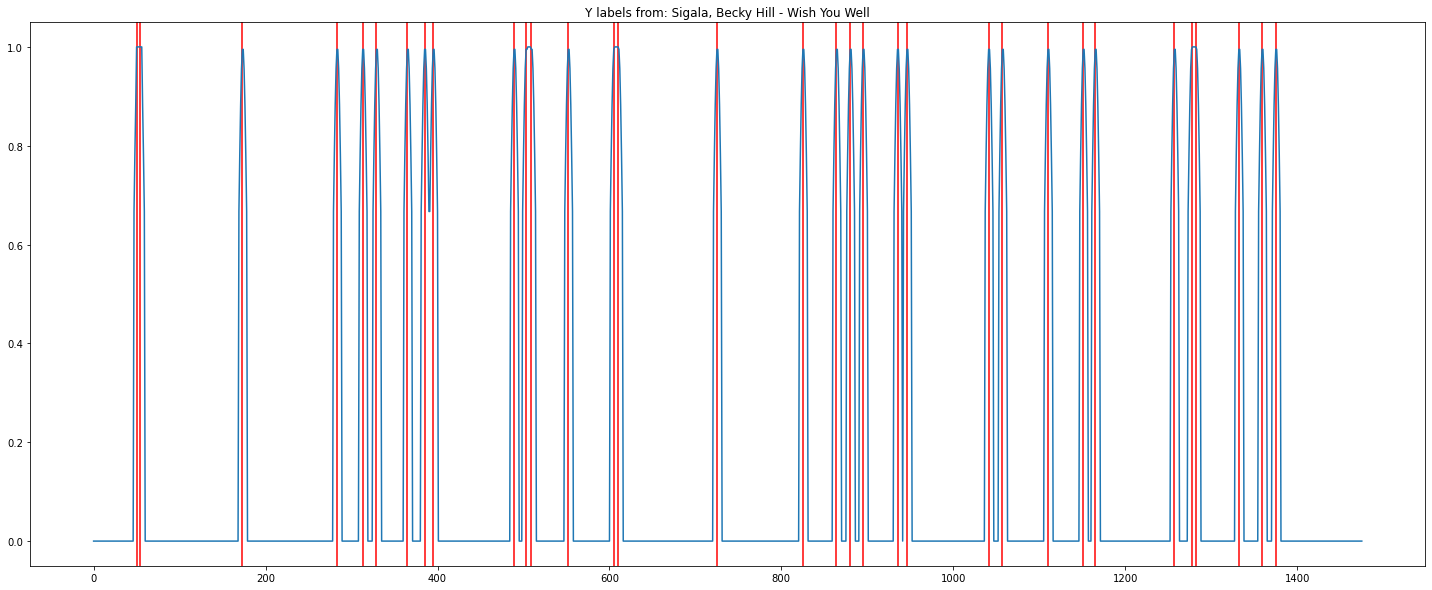

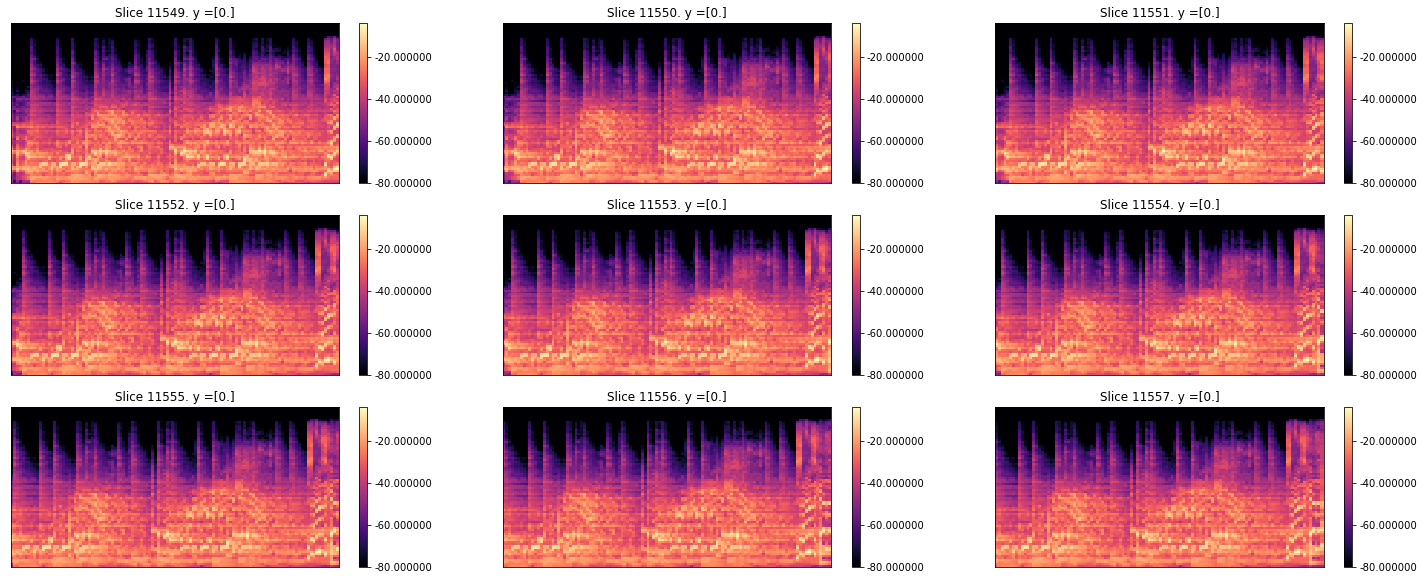

In [26]:
train.show_features(n_song=9)

In [140]:
y_info

{'07.  Regard  -  Ride It': (233, 0.103),
 "15.  Adel Tawil feat. Peachy  -  Tu M'appelles": (329, 0.112),
 '15.  Dan x Shay & Justin Bieber  -  10,000 Hours': (328, 0.136),
 'Marshmello ft Bastille-Happier': (318, 0.095),
 'Nervo-Hold-on': (305, 0.119),
 'Nervo-Skazi-faded': (354, 0.126),
 'Nicky-Romero-Love-you-forever': (244, 0.072),
 'Sofi-tukker-Feeling-good': (202, 0.077),
 'Stream - 9PM (Till I Come)': (250, 0.101),
 'VIZE feat. Laniia - Stars': (275, 0.112)}

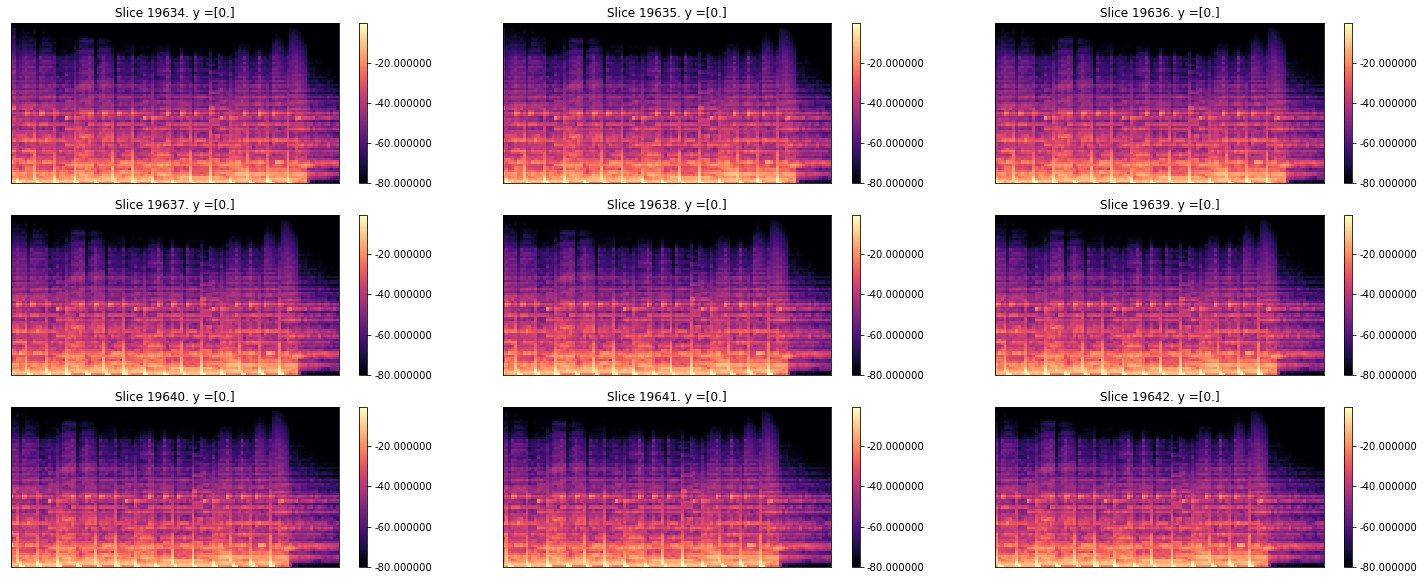

In [148]:
import librosa.display
import IPython.display as lpd # Listening the audio
import matplotlib.pyplot as plt # Plotting coefficients


fig = plt.figure(figsize=(25,10))  
columns = 3
rows = 3
slice = 155
slice = random.randint(0, test_x.shape[0] - columns*rows)

for i in range(1, columns*rows + 1):
    plt.subplot(rows,columns,i, ymargin=20)
    img = test_x[i+slice,:,:,0].T
    librosa.display.specshow(img, sr=44100, hop_length=1024)
    plt.colorbar(format="%+2f")
    plt.title(f'Slice {i+slice}. y ={test_y[i+slice,:]}')
plt.show()

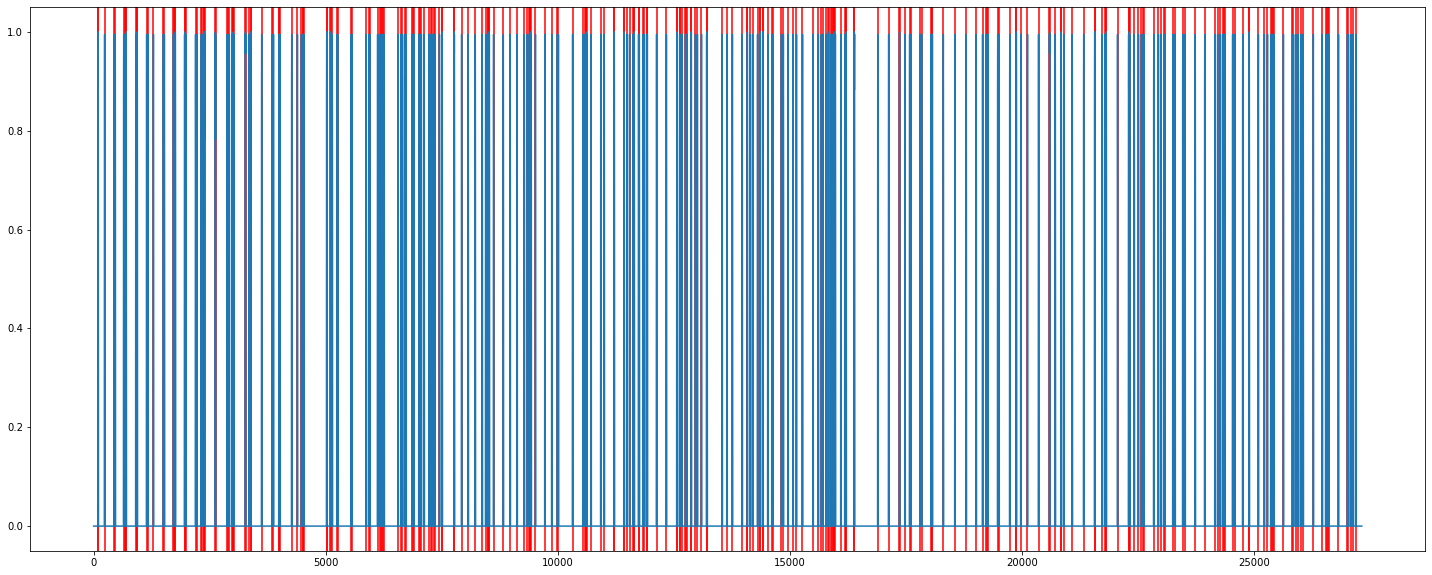

In [146]:
y_labels_index = np.where(y_label > 0)[0]
plt.figure(figsize=(25,10))
for index in y_labels_index:
    plt.axvline(x=index, color="r")
plt.plot(test_y)

Text(0.5, 1.0, 'Augmented zone from y: 19633 to y: 19833')

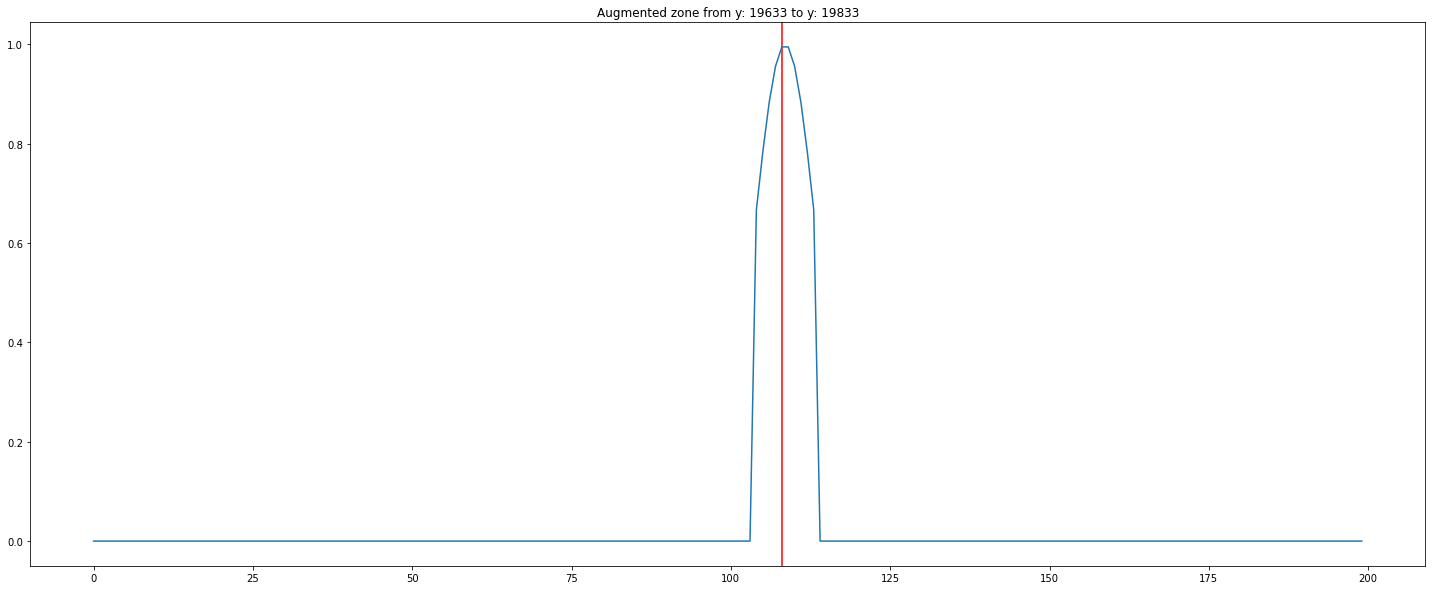

In [149]:
plt.figure(figsize=(25,10))
y_labels_slice = y_label[slice:slice+200,0]
y_labels_index = np.where(y_labels_slice > 0)[0]
y_convolve_slice = test_y[slice:slice+200,0]
for index in y_labels_index:
    plt.axvline(x=index, color="r")
plt.plot(y_convolve_slice)
plt.title(f"Augmented zone from y: {slice} to y: {slice+200}")

In [399]:
%save dataset.py 395 396 397 398

The following commands were written to file `dataset.py`:
import numpy as np
import random
import os
import librosa.display
import IPython.display as lpd # Listening the audio
import matplotlib.pyplot as plt # Plotting coefficients
# Global variables
AUDIO_TRAIN_PATH = "../Data/Audio/Train"
AUDIO_VAL_PATH = "../Data/Audio/Val"
AUDIO_TEST_PATH = "../Data/Audio/Test"

LABELS_TRAIN_PATH = "../Data/Tags/Train"
LABELS_VAL_PATH = "../Data/Tags/Val"
LABELS_TEST_PATH = "../Data/Tags/Test"
def total_positives(smeared_data):
    
    total = smeared_data.shape[0]
    positive_labels_count = [1 for label in smeared_data if label > 0]
    pos = len(positive_labels_count)
    
    return pos, round(pos/total,3)

def get_paths(dataset, resolution, context):
   
    """ Get directory paths"""
    
    if dataset.lower() == "train":
        audio_dir = AUDIO_TRAIN_PATH
        labels_dir = LABELS_TRAIN_PATH
    elif dataset.lower() == "val":
        audio_dir = AUDIO_VAL_PATH
        labels_dir = LABE